# Import libraries

In [ ]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
#from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import folium
import rasterio
from osgeo import gdal
!pip install geopandas fiona
import geopandas
import fiona
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
!pip install pyshp
import shapefile

     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 46 kB 2.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 190 kB/s 
     |████████████████████████████████| 6.3 MB 80.6 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.7.1-py3-none-any.whl size=54118 sha256=a006cac9369c4579aa34f015abd004c2757d3c1e98ae043ea655ddc323a8bb8b
  Stored in directory: /root/.cache/pip/wheels/42/9b/1c/acf2904f7ee44be3c0b8ffc7ea4fafebb135aee00242bef86f
Successfully built rioxarray
     |████████████████████████████████| 1.0 MB 9.0 MB/s 
     |████████████████████████████████| 15.4 MB 81.9 MB/s 
     |████████████████████████████████| 219 kB 5.7 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=2585a04b7a63dad4053860ff41569975fd9651b0ec187366a17eb7612ac13c13
  Stored in directory: /root/.cac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def reconstruct_image(model, image, rounded=False, cmap = 'gray'):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction, cmap = cmap) 

def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(512,512)
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

# Ingest data

## 3-dim data

In [ ]:
download = True

# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

In [ ]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [ ]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(512,512,3)
  test_images[i] = test_images[i].astype('float32')

## 4-band data

### Amazon

In [ ]:
# Download data (Amazon)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()

base_dir2 = r"./AMAZON/"

In [ ]:
# Ingest images

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

In [ ]:
# Pre-process data
for i in range(len(training_images2)):
  #training_images2[i] = training_images2[i].reshape(1,512,512,4)
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  #training_masks[i] = training_masks[i][:512,:512]
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  #validation_images2[i] = validation_images2[i].reshape(1,512,512,4)
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  #validation_masks2[i] = validation_masks2[i][:512,:512]
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  #test_images2[i] = test_images2[i].reshape(1,512,512,4)
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  #test_masks2[i] = test_masks2[i][:512,:512]
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T


for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

### Atlantic

In [ ]:
# Download data (Atlantic Forest)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()

base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Ingest images

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data
for i in range(len(training_images3)):
  #training_images3[i] = training_images3[i].reshape(1,512,512,4)
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  #training_masks3[i] = training_masks3[i][:512,:512]
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  #validation_images3[i] = validation_images3[i].reshape(1,512,512,4)
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  #validation_masks3[i] = validation_masks3[i][:512,:512]
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  #test_images3[i] = test_images3[i].reshape(1,512,512,4)
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  #test_masks3[i] = test_masks3[i][:512,:512]
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

# Models

## U-Net

In [ ]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def UNet(trained_weights = None, input_size = (512,512,4), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    #up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    #up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    #up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    #up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')


    model = Model(inputs, conv10)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

## Attention U-Net

In [ ]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
def spatial_attention(x):

  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

  concat = concatenate([avg_pool, max_pool], axis=3)

  #out = convBlock(concat, 2, 2, act='sigmoid')
  out = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = 'he_normal')(concat)
  out = Activation('sigmoid')(out)

  out = multiply([x, out])

  return out


def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    ##phi_g = Conv2DTranspose(inter_shape, kernel_size = 2, strides = 2, padding = 'same', kernel_initializer='he_normal')(phi_g)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    #upsample_psi = Conv2DTranspose(K.int_shape(sigmoid_xg)[3], 2, 2, kernel_initializer='he_normal')(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])
    ##y = Conv2D(K.int_shape(y)[3], 1, 1, kernel_initializer='he_normal')(y)

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0005, filter_base=16):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    ##up4 = (UpSampling2D(size = (2,2))(conv3))
    #up4 = convBlock(up4, 8 * filter_base, kernel=3)
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    ##up5 = (UpSampling2D(size = (2,2))(conv4))
    #up5 = convBlock(up5, 4 * filter_base, kernel=3)
    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    ##up6 = (UpSampling2D(size = (2,2))(conv5))
    #up6 = convBlock(up6, 2 * filter_base, kernel=3)
    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    ##up7 = (UpSampling2D(size = (2,2))(conv6))
    #up7 = convBlock(up7, 1 * filter_base, kernel=3)
    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

## ResNet50-SegNet

In [ ]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        #self.padding = padding
        #self.pool_size = pool_size
        #self.strides = strides

    def call(self, inputs, **kwargs):
        padding = 'same'#self.padding
        pool_size = (2,2)#self.pool_size
        strides = (2,2)#self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

# Own custom code
def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)
  #out = Conv2DTranspose(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)#MaxPooling2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)#K.tf.nn.max_pool_with_argmax(block2, 2, 2, 'SAME')#MaxPooling2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)#MaxPooling2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)#MaxPooling2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)#MaxPooling2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

## FCN32-VGG16

In [ ]:
def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)


    #o = Conv2D(1,1,1)(o)
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

## ResUNet

In [ ]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]
            
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])
    
    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and 
    final convolution. The input is then put through 
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    #x1 = tf.keras.layers.BatchNormalization()(x)
    #x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Activation('relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
                                                            
    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function 
    in detail. Original Unet uses a transpose convolution that downsamples 
    the number of feature maps. In order to restrict the number of 
    parameters here we use a bilinear resampling layer. This results in 
    the concatentation layer concatenting feature maps with n and n/2 
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized
        
def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same', 
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [ ]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
layer1_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           layer1_1[0][0]                   
__________________________________________________________________________________________________
layer1_shortcut (Conv2D)        (None, 512, 512, 64) 256         input_1[0][0]                    
______________________________________________________________________________________________

# Import Trained Models

In [ ]:
!cp drive/MyDrive/Diss/models/* .

In [ ]:
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

resunet_3d = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
resunet_3d.load_weights('resunet-3d.hdf5')
resunet_4d_amazon = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_4d_amazon.load_weights('resunet-4d.hdf5')
resunet_4d_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_4d_atlantic.load_weights('resunet-4d-atlantic.hdf5')

# Find prediction time for each model

In [ ]:
import time

In [ ]:
def predictor_time(model, image):
  start_time = time.time()
  a = model.predict(image)#.reshape(1,image.shape[0], image.shape[1], image.shape[2]))
  current_time = time.time()
  return current_time - start_time


In [ ]:
print('RGB image prediction times')
print('--------------------------')
print('U-Net: ', predictor_time(unet, validation_images[0]))
print('Attention U-Net: ', predictor_time(attention_unet, validation_images[0]))
print('ResNet50-SegNet: ', predictor_time(resnet_3d, validation_images[0]))
print('FCN32-VGG16: ', predictor_time(fcn32_3d, validation_images[0]))
print('ResUNet: ', predictor_time(resunet_3d, validation_images[0]))

RGB image prediction times
--------------------------
U-Net:  0.07457709312438965
Attention U-Net:  0.04329872131347656
ResNet50-SegNet:  0.1568458080291748
FCN32-VGG16:  0.08843493461608887
ResUNet:  0.08837270736694336


In [ ]:
print('4-band image prediction times')
print('--------------------------')
print('U-Net: ', predictor_time(unet_4d, validation_images2[0]))
print('Attention U-Net: ', predictor_time(attention_unet_4d, validation_images2[0]))
print('ResNet50-SegNet: ', predictor_time(resnet_4d_amazon, validation_images2[0]))
print('FCN32-VGG16: ', predictor_time(fcn32_4d_amazon, validation_images2[0]))
print('ResUNet: ', predictor_time(resunet_4d_amazon, validation_images2[0]))

4-band image prediction times
--------------------------
U-Net:  0.08200883865356445
Attention U-Net:  0.054075002670288086
ResNet50-SegNet:  0.1583728790283203
FCN32-VGG16:  0.09713912010192871
ResUNet:  0.09236550331115723


# Compute Jaccard Index

In [ ]:
def jaccard_index(model, images, masks):

  preds = []
  for n in images:
    preds.append(reconstruct_array(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred = preds[i].flatten()
    flat_act =  masks[i].flatten()

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append(jaccard_score(flat_act, flat_pred, average='weighted'))

  return np.mean(jaccard_list), np.std(jaccard_list)

In [ ]:
def dice_coefficient(model, images, masks): # Forked from: https://gist.github.com/JDWarner/6730747

  preds = []
  for n in images:
    preds.append(reconstruct_array(model, n, rounded=True))

  dice_list = []

  # dice = 2|X int Y| / (|X| + |Y|)
  # dice = 2TP / (2TP + FP + FN)
  for i in range(len(preds)):
    flat_pred = preds[i].flatten()
    flat_act =  masks[i].flatten()

    diff = np.logical_and(flat_pred, flat_act)

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    dice_list.append((2*diff.sum() + 0.0001)/(flat_pred.sum() + flat_act.sum() + 0.0001))

  return np.mean(dice_list), np.std(dice_list)

In [ ]:
# Find Jaccard Index coeff for 3d dataset
unet_3d_jaccard = jaccard_index(unet, validation_images, validation_masks)
attention_unet_3d_jaccard = jaccard_index(attention_unet, validation_images, validation_masks)
resnet_3d_jaccard = jaccard_index(resnet_3d, validation_images, validation_masks)
fcn32_3d_jaccard = jaccard_index(fcn32_3d, validation_images, validation_masks)
resunet_3d_jaccard = jaccard_index(resunet_3d, validation_images, validation_masks)

print('U-Net Jaccard Index: ', unet_3d_jaccard)
print('Attention U-Net Jaccard Index: ', attention_unet_3d_jaccard)
print('ResNet50-SegNet Jaccard Index: ', resnet_3d_jaccard)
print('FCN32-VGG16 Jaccard Index: ', fcn32_3d_jaccard)
print('ResUNet Jaccard Index: ', resunet_3d_jaccard)

U-Net Jaccard Index:  (0.8888171069519725, 0.09540051385520305)
Attention U-Net Jaccard Index:  (0.9028301582054242, 0.06956019512982896)
ResNet50-SegNet Jaccard Index:  (0.8975587982257588, 0.08849748041277453)
FCN32-VGG16 Jaccard Index:  (0.8197782256504966, 0.11453357480375649)
ResUNet Jaccard Index:  (0.9127458474844393, 0.07799331063969057)


In [ ]:
# Find Jaccard Index coeff for 4d Amazon dataset
unet_4d_jaccard = jaccard_index(unet_4d, validation_images2, validation_masks2)
attention_unet_4d_jaccard = jaccard_index(attention_unet_4d, validation_images2, validation_masks2)
resnet_4d_jaccard = jaccard_index(resnet_4d_amazon, validation_images2, validation_masks2)
fcn32_4d_jaccard = jaccard_index(fcn32_4d_amazon, validation_images2, validation_masks2)
resunet_4d_jaccard = jaccard_index(resunet_4d_amazon, validation_images2, validation_masks2)

print('U-Net Jaccard Index: ', unet_4d_jaccard)
print('Attention U-Net Jaccard Index: ', attention_unet_4d_jaccard)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d_jaccard)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d_jaccard)
print('ResUNet Jaccard Index: ', resunet_4d_jaccard)

U-Net Jaccard Index:  (0.9530175925359171, 0.041770993112146035)
Attention U-Net Jaccard Index:  (0.9581004122099591, 0.03888695695334564)
ResNet50-SegNet Jaccard Index:  (0.9467245333730016, 0.04257611700535748)
FCN32-VGG16 Jaccard Index:  (0.8592048932285036, 0.07352161501641498)
ResUNet Jaccard Index:  (0.9431786807575127, 0.04667140276638357)


In [ ]:
# Find Jaccard Index coeff for 4d Atlantic Forest dataset
unet_4d1_jaccard = jaccard_index(unet_4d_atlantic, validation_images3, validation_masks3)
attention_unet_4d1_jaccard = jaccard_index(attention_unet_4d_atlantic, validation_images3, validation_masks3)
resnet_4d1_jaccard = jaccard_index(resnet_4d_atlantic, validation_images3, validation_masks3)
fcn32_4d1_jaccard = jaccard_index(fcn32_4d_atlantic, validation_images3, validation_masks3)
resunet_4d1_jaccard = jaccard_index(resunet_4d_atlantic, validation_images3, validation_masks3)

print('U-Net Jaccard Index: ', unet_4d1_jaccard)
print('Attention U-Net Jaccard Index: ', attention_unet_4d1_jaccard)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d1_jaccard)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d1_jaccard)
print('ResUNet Jaccard Index: ', resunet_4d1_jaccard)

U-Net Jaccard Index:  (0.8818145695535151, 0.07970337097962799)
Attention U-Net Jaccard Index:  (0.9119998998289711, 0.0499195670179365)
ResNet50-SegNet Jaccard Index:  (0.9043172149586589, 0.04725162526698119)
FCN32-VGG16 Jaccard Index:  (0.7181839065312474, 0.09060434573224835)
ResUNet Jaccard Index:  (0.9101532306476697, 0.04874027129505062)


In [ ]:
# Find Jaccard Index coeff for 4d Amazon test dataset
unet_4d_jaccard_test = jaccard_index(unet_4d, test_images2, test_masks2)
attention_unet_4d_jaccard_test = jaccard_index(attention_unet_4d, test_images2, test_masks2)
resnet_4d_jaccard_test = jaccard_index(resnet_4d_amazon, test_images2, test_masks2)
fcn32_4d_jaccard_test = jaccard_index(fcn32_4d_amazon, test_images2, test_masks2)
resunet_4d_jaccard_test = jaccard_index(resunet_4d_amazon, test_images2, test_masks2)

print('U-Net Jaccard Index: ', unet_4d_jaccard_test)
print('Attention U-Net Jaccard Index: ', attention_unet_4d_jaccard_test)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d_jaccard_test)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d_jaccard_test)
print('ResUNet Jaccard Index: ', resunet_4d_jaccard_test)

U-Net Jaccard Index:  (0.947257871770282, 0.039804483381044996)
Attention U-Net Jaccard Index:  (0.9516401502284074, 0.0371020344056209)
ResNet50-SegNet Jaccard Index:  (0.9416153332209045, 0.03920805470652662)
FCN32-VGG16 Jaccard Index:  (0.8556726268262024, 0.05500761317423428)
ResUNet Jaccard Index:  (0.9428987614617548, 0.033998769071865956)


In [ ]:
# Find Jaccard Index coeff for 4d Atlantic Forest test dataset
unet_4d1_jaccard_test = jaccard_index(unet_4d_atlantic, test_images3, test_masks3)
attention_unet_4d1_jaccard_test = jaccard_index(attention_unet_4d_atlantic, test_images3, test_masks3)
resnet_4d1_jaccard_test = jaccard_index(resnet_4d_atlantic, test_images3, test_masks3)
fcn32_4d1_jaccard_test = jaccard_index(fcn32_4d_atlantic, test_images3, test_masks3)
resunet_4d1_jaccard_test = jaccard_index(resunet_4d_atlantic, test_images3, test_masks3)

print('U-Net Jaccard Index: ', unet_4d1_jaccard_test)
print('Attention U-Net Jaccard Index: ', attention_unet_4d1_jaccard_test)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d1_jaccard_test)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d1_jaccard_test)
print('ResUNet Jaccard Index: ', resunet_4d1_jaccard_test)

U-Net Jaccard Index:  (0.8883408565252571, 0.07795501918786182)
Attention U-Net Jaccard Index:  (0.9198655201205588, 0.023898487620027987)
ResNet50-SegNet Jaccard Index:  (0.9025805430046848, 0.04512040128710714)
FCN32-VGG16 Jaccard Index:  (0.6901690447030971, 0.10983197399089627)
ResUNet Jaccard Index:  (0.9073089716991906, 0.049149251967388737)


In [ ]:
# Find Jaccard Index coeff for 4d Amazon dataset tested on Atlantic Forest data
unet_4d_jaccard_onatl = jaccard_index(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
attention_unet_4d_jaccard_onatl = jaccard_index(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
resnet_4d_jaccard_onatl = jaccard_index(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3)
fcn32_4d_jaccard_onatl = jaccard_index(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3)
resunet_4d_jaccard_onatl = jaccard_index(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3)

print('U-Net Jaccard Index: ', unet_4d_jaccard_onatl)
print('Attention U-Net Jaccard Index: ', attention_unet_4d_jaccard_onatl)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d_jaccard_onatl)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d_jaccard_onatl)
print('ResUNet Jaccard Index: ', resunet_4d_jaccard_onatl)

U-Net Jaccard Index:  (0.8133614034973548, 0.11702759918168715)
Attention U-Net Jaccard Index:  (0.8142570454195891, 0.13561072908003483)
ResNet50-SegNet Jaccard Index:  (0.7921238651513446, 0.14292655876966656)
FCN32-VGG16 Jaccard Index:  (0.6797365469706764, 0.13198761076610846)
ResUNet Jaccard Index:  (0.7706620698788065, 0.16225248922262828)


In [ ]:
# Find Jaccard Index coeff for 4d Atlantic Forest dataset tested on Amazon dataset
unet_4d1_jaccard_onam = jaccard_index(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
attention_unet_4d1_jaccard_onam = jaccard_index(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
resnet_4d1_jaccard_onam = jaccard_index(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
fcn32_4d1_jaccard_onam = jaccard_index(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
resunet_4d1_jaccard_onam = jaccard_index(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

print('U-Net Jaccard Index: ', unet_4d1_jaccard)
print('Attention U-Net Jaccard Index: ', attention_unet_4d1_jaccard)
print('ResNet50-SegNet Jaccard Index: ', resnet_4d1_jaccard)
print('FCN32-VGG16 Jaccard Index: ', fcn32_4d1_jaccard)
print('ResUNet Jaccard Index: ', resunet_4d1_jaccard)

U-Net Jaccard Index:  (0.8818145695535151, 0.07970337097962799)
Attention U-Net Jaccard Index:  (0.9119998998289711, 0.0499195670179365)
ResNet50-SegNet Jaccard Index:  (0.9043172149586589, 0.04725162526698119)
FCN32-VGG16 Jaccard Index:  (0.7181839065312474, 0.09060434573224835)
ResUNet Jaccard Index:  (0.9101532306476697, 0.04874027129505062)


In [ ]:
# Output to file
unet_jac      = [unet_3d_jaccard[0], unet_4d_jaccard[0], unet_4d1_jaccard[0], unet_4d_jaccard_test[0], unet_4d1_jaccard_test[0], unet_4d_jaccard_onatl[0], unet_4d1_jaccard_onam[0]]
att_unet_jac  = [attention_unet_3d_jaccard[0], attention_unet_4d_jaccard[0], attention_unet_4d1_jaccard[0], attention_unet_4d_jaccard_test[0], attention_unet_4d1_jaccard_test[0], attention_unet_4d_jaccard_onatl[0], attention_unet_4d1_jaccard_onam[0]]
resnet_jac    = [resnet_3d_jaccard[0], resnet_4d_jaccard[0], resnet_4d1_jaccard[0], resnet_4d_jaccard_test[0], resnet_4d1_jaccard_test[0], resnet_4d_jaccard_onatl[0], resnet_4d1_jaccard_onam[0]]
fcn32_jac     = [fcn32_3d_jaccard[0], fcn32_4d_jaccard[0], fcn32_4d1_jaccard[0], fcn32_4d_jaccard_test[0], fcn32_4d1_jaccard_test[0], fcn32_4d_jaccard_onatl[0], fcn32_4d1_jaccard_onam[0]]
resunet_jac     = [resunet_3d_jaccard[0], resunet_4d_jaccard[0], resunet_4d1_jaccard[0], resunet_4d_jaccard_test[0], resunet_4d1_jaccard_test[0], resunet_4d_jaccard_onatl[0], resunet_4d1_jaccard_onam[0]]

jm = [unet_jac, att_unet_jac, resnet_jac, fcn32_jac, resunet_jac]

# Create lists of all types of Jaccard metrics
jac_3d                  = [n[0] for n in jm]
jac_amazon              = [n[1] for n in jm]
jac_atlantic            = [n[2] for n in jm]
jac_amazon_test         = [n[3] for n in jm]
jac_atlantic_test       = [n[4] for n in jm]
jac_amazon_on_atlantic  = [n[5] for n in jm]
jac_atlantic_on_amazon  = [n[6] for n in jm]


import pandas as pd
jaccard_metrics = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              '3d': jac_3d,
              'amazon': jac_amazon,
              'atlantic': jac_atlantic,
              'amazon_test': jac_amazon_test,
              'atlantic_test': jac_atlantic_test,
              'amazon_on_atlantic': jac_amazon_on_atlantic,
              'atlantic_on_amazon': jac_atlantic_on_amazon
              }
jaccard_metrics = pd.DataFrame(jaccard_metrics)
jaccard_metrics.to_csv('jaccard_metrics.csv')

# Get confusion matrices

In [ ]:
predictions_3d_unet = [list(reconstruct_array(unet, n, True).flatten()) for n in validation_images]
actual_3d      = [list(n.flatten()) for n in validation_masks]
predictions_3d_att_unet = [list(reconstruct_array(attention_unet, n, True).flatten()) for n in validation_images]

predictions_4d_unet = [list(reconstruct_array(unet_4d, n, True).flatten()) for n in validation_images2]
actual_4d      = [list(n.flatten()) for n in validation_masks2]
predictions_4d_att_unet = [list(reconstruct_array(attention_unet_4d, n, True).flatten()) for n in validation_images2]

predictions_4d_atl_unet = [list(reconstruct_array(unet_4d_atlantic, n, True).flatten()) for n in validation_images3]
actual_4d_atl      = [list(n.flatten()) for n in validation_masks3]
predictions_4d_atl_att_unet = [list(reconstruct_array(attention_unet_4d_atlantic, n, True).flatten()) for n in validation_images3]

# Make lists for confmat
import itertools
p3u   = list(itertools.chain.from_iterable(predictions_3d_unet))
p3au  = list(itertools.chain.from_iterable(predictions_3d_att_unet))
a3u   = list(itertools.chain.from_iterable(actual_3d))

p4u   = list(itertools.chain.from_iterable(predictions_4d_unet))
p4au  = list(itertools.chain.from_iterable(predictions_4d_att_unet))
a4u   = list(itertools.chain.from_iterable(actual_4d))

p4atlu   = list(itertools.chain.from_iterable(predictions_4d_atl_unet))
p4atlau  = list(itertools.chain.from_iterable(predictions_4d_atl_att_unet))
a4atlu   = list(itertools.chain.from_iterable(actual_4d_atl))

unet_3d_confmat = confusion_matrix(a3u, p3u)
attention_unet_3d_confmat = confusion_matrix(a3u, p3au)

unet_4d_confmat = confusion_matrix(a4u, p4u)
attention_unet_4d_confmat = confusion_matrix(a4u, p4au)

unet_4d_atl_confmat = confusion_matrix(a4atlu, p4atlu)
attention_unet_4d_atl_confmat = confusion_matrix(a4atlu, p4atlau)


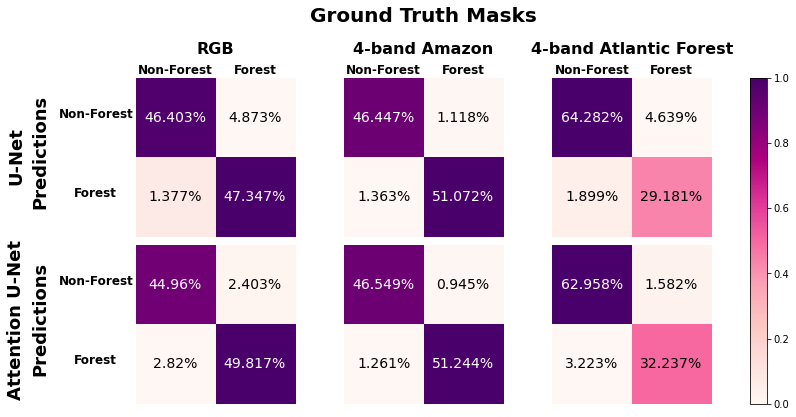

In [ ]:
# Using code from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, axs = plt.subplots(2, 3, figsize=(14,6))
axs[0,0].set_xticks(np.arange(len(['Forest', 'Non-Forest'])))
axs[0,0].set_yticks(np.arange(len(['Forest', 'Non-Forest'])))

# Set labels of axes
axs[0,0].set_xticklabels(['Forest', 'Non-Forest'], size=14)
axs[0,0].set_yticklabels(['Forest', 'Non-Forest'], size=14)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
#         rotation_mode="anchor", size=14)

# Create text labels
rounding = 3
sz = 14
col = 'black'

for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,0].text(i, j, '{}%'.format(np.round(100*unet_3d_confmat[i, j]/unet_3d_confmat.sum(), rounding)),
                      ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,1].text(i, j, '{}%'.format(np.round(100*unet_4d_confmat[i, j]/unet_4d_confmat.sum(), rounding)),
                      ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,2].text(i, j, '{}%'.format(np.round(100*unet_4d_atl_confmat[i, j]/unet_4d_atl_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,0].text(i, j, '{}%'.format(np.round(100*attention_unet_3d_confmat[i, j]/attention_unet_3d_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,1].text(i, j, '{}%'.format(np.round(100*attention_unet_4d_confmat[i, j]/attention_unet_4d_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        

for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,2].text(i, j, '{}%'.format(np.round(100*attention_unet_4d_atl_confmat[i, j]/attention_unet_4d_atl_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
# Remove axis, adjust spacing
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')

# Add titles
axs[0,1].text(0.5,1.35, "Ground Truth Masks", size=20, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,0].text(0.5,1.15, "RGB", size=16, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")

axs[0,1].text(0.5,1.15, "4-band Amazon", size=16, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,2].text(0.5,1.15, "4-band Atlantic Forest", size=16, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")

# Plot
tone = 'RdPu'
axs[0,0].imshow(unet_3d_confmat, cmap=tone)
axs[0,1].imshow(unet_4d_confmat, cmap=tone)
axs[0,2].imshow(unet_4d_atl_confmat, cmap=tone)
axs[1,0].imshow(attention_unet_3d_confmat, cmap=tone)
axs[1,1].imshow(attention_unet_4d_confmat, cmap=tone)
axs[1,2].imshow(attention_unet_4d_atl_confmat, cmap=tone)

# Add classifier labels
axs[0,0].text(-0.75,0.35, "U-Net", size=18, ha="center", 
         transform=axs[0,0].transAxes, weight="bold", rotation=90)
axs[1,0].text(-0.75,0.05, "Attention U-Net", size=18, ha="center", 
         transform=axs[1,0].transAxes, weight="bold", rotation=90)
#axs[1,0].text(-0.75,0.35, "U-Net", size=18, ha="center", 
#         transform=axs[1,0].transAxes, weight="bold", rotation=90)
axs[0,0].text(-0.6,0.2, "Predictions", size=18, ha="center", 
         transform=axs[0,0].transAxes, weight="bold", rotation=90)
axs[1,0].text(-0.6,0.2, "Predictions", size=18, ha="center", 
         transform=axs[1,0].transAxes, weight="bold", rotation=90)

# Add left labels
axs[0,0].text(-0.25,0.75, "Non-Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[0,0].text(-0.25,0.25, "Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[1,0].text(-0.25,0.75, "Non-Forest", size=12, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")
axs[1,0].text(-0.25,0.25, "Forest", size=12, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")

# Add top labels
axs[0,0].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[0,0].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")

axs[0,1].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")
axs[0,1].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,2].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")
axs[0,2].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")


fig.subplots_adjust(wspace=0, hspace=0.05)
fig.colorbar(plt.cm.ScalarMappable(cmap=tone), ax=axs)
fig.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0.1)

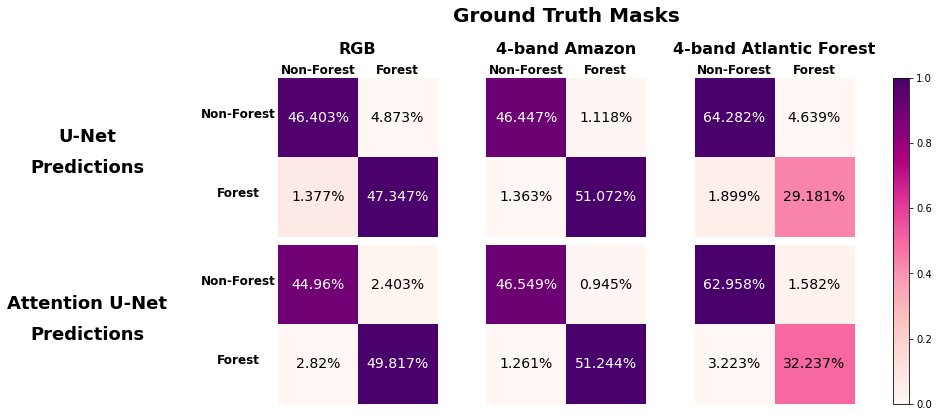

In [ ]:
# Using code from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
# Version with non-rotated left labels
fig, axs = plt.subplots(2, 3, figsize=(14,6))
axs[0,0].set_xticks(np.arange(len(['Forest', 'Non-Forest'])))
axs[0,0].set_yticks(np.arange(len(['Forest', 'Non-Forest'])))

# Set labels of axes
axs[0,0].set_xticklabels(['Forest', 'Non-Forest'], size=14)
axs[0,0].set_yticklabels(['Forest', 'Non-Forest'], size=14)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
#         rotation_mode="anchor", size=14)

# Create text labels
rounding = 3
sz = 14
col = 'black'

for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,0].text(i, j, '{}%'.format(np.round(100*unet_3d_confmat[i, j]/unet_3d_confmat.sum(), rounding)),
                      ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,1].text(i, j, '{}%'.format(np.round(100*unet_4d_confmat[i, j]/unet_4d_confmat.sum(), rounding)),
                      ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0,2].text(i, j, '{}%'.format(np.round(100*unet_4d_atl_confmat[i, j]/unet_4d_atl_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,0].text(i, j, '{}%'.format(np.round(100*attention_unet_3d_confmat[i, j]/attention_unet_3d_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,1].text(i, j, '{}%'.format(np.round(100*attention_unet_4d_confmat[i, j]/attention_unet_4d_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        

for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1,2].text(i, j, '{}%'.format(np.round(100*attention_unet_4d_atl_confmat[i, j]/attention_unet_4d_atl_confmat.sum(), rounding)),
                       ha="center", va="center", color=col2, size=sz)
        
# Remove axis, adjust spacing
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')

# Add titles
axs[0,1].text(0.5,1.35, "Ground Truth Masks", size=20, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,0].text(0.5,1.15, "RGB", size=16, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")

axs[0,1].text(0.5,1.15, "4-band Amazon", size=16, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,2].text(0.5,1.15, "4-band Atlantic Forest", size=16, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")

# Plot
tone = 'RdPu'
axs[0,0].imshow(unet_3d_confmat, cmap=tone)
axs[0,1].imshow(unet_4d_confmat, cmap=tone)
axs[0,2].imshow(unet_4d_atl_confmat, cmap=tone)
axs[1,0].imshow(attention_unet_3d_confmat, cmap=tone)
axs[1,1].imshow(attention_unet_4d_confmat, cmap=tone)
axs[1,2].imshow(attention_unet_4d_atl_confmat, cmap=tone)

# Add classifier labels
axs[0,0].text(-1.2,0.6, "U-Net", size=18, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[1,0].text(-1.2,0.6, "Attention U-Net", size=18, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")
#axs[1,0].text(-0.75,0.35, "U-Net", size=18, ha="center", 
#         transform=axs[1,0].transAxes, weight="bold", rotation=90)
axs[0,0].text(-1.2,0.4, "Predictions", size=18, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[1,0].text(-1.2,0.4, "Predictions", size=18, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")

# Add left labels
axs[0,0].text(-0.25,0.75, "Non-Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[0,0].text(-0.25,0.25, "Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[1,0].text(-0.25,0.75, "Non-Forest", size=12, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")
axs[1,0].text(-0.25,0.25, "Forest", size=12, ha="center", 
         transform=axs[1,0].transAxes, weight="bold")

# Add top labels
axs[0,0].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")
axs[0,0].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,0].transAxes, weight="bold")

axs[0,1].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")
axs[0,1].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,1].transAxes, weight="bold")

axs[0,2].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")
axs[0,2].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0,2].transAxes, weight="bold")


fig.subplots_adjust(wspace=0, hspace=0.05)
fig.colorbar(plt.cm.ScalarMappable(cmap=tone), ax=axs)
fig.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0.1)

# Plot ground truth and predictions

In [ ]:
# Set custom plot font
#custom_font = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "serif"
plt.style.use('seaborn-bright')

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
ind1, ind11 = 7, 7
ind2, ind22 = 8, 7
ind3, ind33 = 15, 7

# Image and mask from 3-dim data
im_1 = validation_images[ind1]#.reshape(512,512,3)
mk_1 = validation_masks[ind1]#.reshape(512,512)
im_11 = validation_images[ind11]#.reshape(512,512,3)
mk_11 = validation_masks[ind11]#.reshape(512,512)

# Image and mask from 4-band Amazon data
im_2 = test_images2[ind2]#.reshape(512,512,4)[:,:,0:3]
mk_2 = test_masks2[ind2]#.reshape(512,512)
im_22 = test_images2[ind22]#.reshape(512,512,4)
mk_22 = test_masks2[ind22]#.reshape(512,512)

# Image and mask from 4-band Atlantic data
im_3 = validation_images3[ind3]#.reshape(512,512,4)[:,:,0:3]
mk_3 = validation_masks3[ind3]#.reshape(512,512)
im_33 = validation_images3[ind33]#.reshape(512,512,4)[:,:,0:3]
mk_33 = validation_masks3[ind33]#.reshape(512,512)

# Create reconstructions

# 3D data
ds_3d_unet_1 = reconstruct_array(unet, im_1, rounded=True)
ds_3d_attention_1 = reconstruct_array(attention_unet, im_1, rounded=True)
ds_3d_resnet_1 = reconstruct_array(resnet_3d, im_1, rounded=True)
ds_3d_fcn32_1 = reconstruct_array(fcn32_3d, im_1, rounded=True)
ds_3d_resunet_1 = reconstruct_array(resunet_3d, im_1, rounded=True)

ds_3d_unet_2 = reconstruct_array(unet, im_11, rounded=True)
ds_3d_attention_2 = reconstruct_array(attention_unet, im_11, rounded=True)
ds_3d_resnet_2 = reconstruct_array(resnet_3d, im_11, rounded=True)
ds_3d_fcn32_2 = reconstruct_array(fcn32_3d, im_11, rounded=True)
ds_3d_resunet_2 = reconstruct_array(resunet_3d, im_11, rounded=True)

# 4d Amazon data
ds_4d_unet_1 = reconstruct_array(unet_4d, im_2, rounded=True)
ds_4d_attention_1 = reconstruct_array(attention_unet_4d, im_2, rounded=True)
ds_4d_resnet_1 = reconstruct_array(resnet_4d_amazon, im_2, rounded=True)
ds_4d_fcn32_1 = reconstruct_array(fcn32_4d_amazon, im_2, rounded=True)
ds_4d_resunet_1 = reconstruct_array(resunet_4d_amazon, im_2, rounded=True)

ds_4d_unet_2 = reconstruct_array(unet_4d, im_22, rounded=True)
ds_4d_attention_2 = reconstruct_array(attention_unet_4d, im_22, rounded=True)
ds_4d_resnet_2 = reconstruct_array(resnet_4d_amazon, im_22, rounded=True)
ds_4d_fcn32_2 = reconstruct_array(fcn32_4d_amazon, im_22, rounded=True)
ds_4d_resunet_2 = reconstruct_array(resunet_4d_amazon, im_22, rounded=True)

# 4d Atlantic Forest data
ds_4d2_unet_1 = reconstruct_array(unet_4d_atlantic, im_3, rounded=True)
ds_4d2_attention_1 = reconstruct_array(attention_unet_4d_atlantic, im_3, rounded=True)
ds_4d2_resnet_1 = reconstruct_array(resnet_4d_atlantic, im_3, rounded=True)
ds_4d2_fcn32_1 = reconstruct_array(fcn32_4d_atlantic, im_3, rounded=True)
ds_4d2_resunet_1 = reconstruct_array(resunet_4d_atlantic, im_3, rounded=True)

ds_4d2_unet_2 = reconstruct_array(unet_4d_atlantic, im_33, rounded=True)
ds_4d2_attention_2 = reconstruct_array(attention_unet_4d_atlantic, im_33, rounded=True)
ds_4d2_resnet_2 = reconstruct_array(resnet_4d_atlantic, im_33, rounded=True)
ds_4d2_fcn32_2 = reconstruct_array(fcn32_4d_atlantic, im_33, rounded=True)
ds_4d2_resunet_2 = reconstruct_array(resunet_4d_atlantic, im_33, rounded=True)

## Comparison of 3-dim RGB data

In [ ]:
# Plot images, ground truths, and predictions side by side
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 7, figsize=(21,6))
axs[0].imshow(im_1.reshape(512,512,3))
axs[1].imshow(mk_1.reshape(512,512), cmap='gray')
axs[2].imshow(ds_3d_unet_1, cmap='gray')
axs[3].imshow(ds_3d_resnet_1, cmap='gray')
axs[4].imshow(ds_3d_fcn32_1, cmap='gray')
axs[5].imshow(ds_3d_resunet_1, cmap='gray')
axs[6].imshow(ds_3d_attention_1, cmap='gray')
circle1 = Circle((100, 390), 60, fill=False, linewidth=4, alpha=0.5, color='red')
circle2 = Circle((320, 170), 60, fill=False, linewidth=4, alpha=0.5, color='red')
axs[6].add_artist(circle1)
axs[6].add_artist(circle2)

# Remove axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')
axs[6].axis('off')

# Set equal spacing
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')
axs[4].set_aspect('equal')
axs[5].set_aspect('equal')
axs[6].set_aspect('equal')

# Set titles
axs[0].set_title('Image', size=16)
axs[1].set_title('Ground Truth', size=16)
axs[2].set_title('U-Net', size=16)
axs[3].set_title('ResNet50-SegNet', size=16)
axs[4].set_title('FCN32-VGG16', size=16)
axs[5].set_title('Residual U-Net', size=16)
axs[6].set_title('Attention U-Net', size=16)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('3d-comparison.pdf', bbox_inches = 'tight', pad_inches = 0.1)

### Image 1

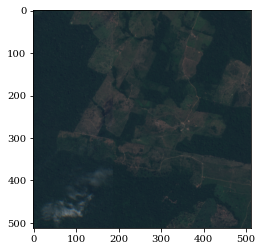

In [ ]:
# Original image
plt.imshow(im_1.reshape(512,512,3))

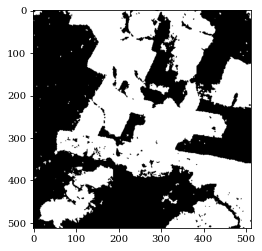

In [ ]:
# Ground truth mask
plt.imshow(mk_1.reshape(512,512), cmap = 'gray')

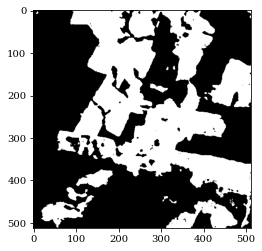

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet, im_1, rounded = True, cmap = 'gray')

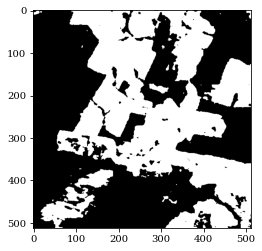

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet, im_1, rounded = True, cmap = 'gray')

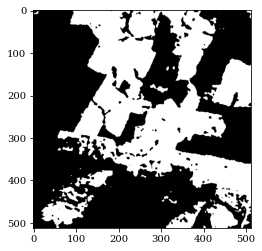

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_3d, im_1, rounded = True, cmap = 'gray')

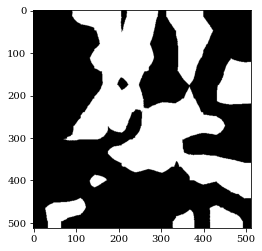

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_3d, im_1, rounded = True, cmap = 'gray')

## Comparison of 4-band Amazon data

In [ ]:
# Plot images, ground truths, and predictions side by side

fig, axs = plt.subplots(1, 7, figsize=(21,6))
axs[0].imshow(2*im_2.reshape(512,512,4)[:,:,0:3]) # 2* image just to brighten it
axs[1].imshow(mk_2.reshape(512,512), cmap='gray')
axs[2].imshow(ds_4d_unet_1, cmap='gray')
axs[3].imshow(ds_4d_resnet_1, cmap='gray')
axs[4].imshow(ds_4d_fcn32_1, cmap='gray')
axs[5].imshow(ds_4d_resunet_1, cmap='gray')
axs[6].imshow(ds_4d_attention_1, cmap='gray')
circle5 = Circle((100, 290), 80, fill=False, linewidth=4, alpha=0.5, color='red')
circle6 = Circle((220, 450), 60, fill=False, linewidth=4, alpha=0.5, color='red')
axs[6].add_artist(circle5)
axs[6].add_artist(circle6)

# Remove axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')
axs[6].axis('off')

# Set equal spacing
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')
axs[4].set_aspect('equal')
axs[5].set_aspect('equal')
axs[6].set_aspect('equal')

# Set titles
axs[0].set_title('Image', size=16)
axs[1].set_title('Ground Truth', size=16)
axs[2].set_title('U-Net', size=16)
axs[3].set_title('ResNet50-SegNet', size=16)
axs[4].set_title('FCN32-VGG16', size=16)
axs[5].set_title('Residual U-Net', size=16)
axs[6].set_title('Attention U-Net', size=16)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('4d-amazon-comparison.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


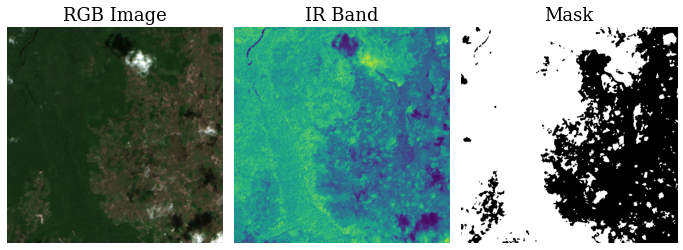

In [ ]:
# Show different bands
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(2*im_2.reshape(512,512,4)[:,:,0:3])
axs[1].imshow(im_2.reshape(512,512,4)[:,:,3])
axs[2].imshow(mk_2.reshape(512,512), cmap='gray')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

axs[0].set_title('RGB Image', size=18)
axs[1].set_title('IR Band', size=18)
axs[2].set_title('Mask', size=18)

fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig('4d-amazon-bands.pdf', bbox_inches = 'tight', pad_inches = 0.1)

### Image 1

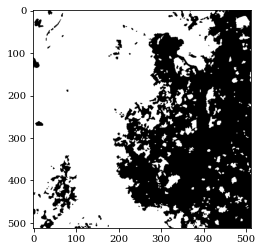

In [ ]:
# Ground truth mask
plt.imshow(mk_2.reshape(512,512), cmap = 'gray')

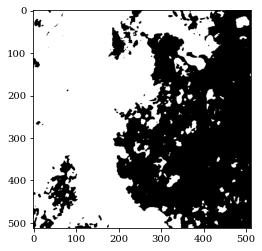

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet_4d, im_2, rounded = True, cmap = 'gray')

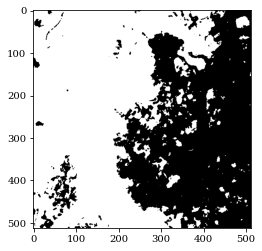

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet_4d, im_2, rounded = True, cmap = 'gray')

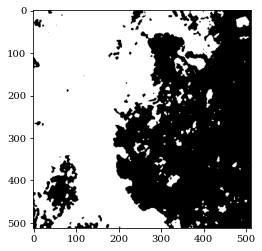

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_4d_amazon, im_2, rounded = True, cmap = 'gray')

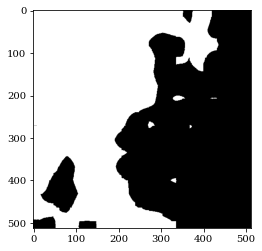

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_4d_amazon, im_2, rounded = True, cmap = 'gray')

## Comparison of 4-band Atlantic data

In [ ]:
# Plot images, ground truths, and predictions side by side

fig, axs = plt.subplots(1, 7, figsize=(21,6))
axs[0].imshow(2*im_3.reshape(512,512,4)[:,:,0:3]) # 2* image just to brighten it
axs[1].imshow(mk_3.reshape(512,512), cmap='gray')
axs[2].imshow(ds_4d2_unet_1, cmap='gray')
axs[3].imshow(ds_4d2_resnet_1, cmap='gray')
axs[4].imshow(ds_4d2_fcn32_1, cmap='gray')
axs[5].imshow(ds_4d2_resunet_1, cmap='gray')
axs[6].imshow(ds_4d2_attention_1, cmap='gray')
circle7 = Circle((300, 400), 80, fill=False, linewidth=4, alpha=0.5, color='red')
circle8 = Circle((100, 400), 80, fill=False, linewidth=4, alpha=0.5, color='red')
axs[6].add_artist(circle7)
axs[6].add_artist(circle8)

# Remove axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')
axs[6].axis('off')

# Set equal spacing
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')
axs[4].set_aspect('equal')
axs[5].set_aspect('equal')
axs[6].set_aspect('equal')

# Set titles
axs[0].set_title('Image', size=16)
axs[1].set_title('Ground Truth', size=16)
axs[2].set_title('U-Net', size=16)
axs[3].set_title('ResNet50-SegNet', size=16)
axs[4].set_title('FCN32-VGG16', size=16)
axs[5].set_title('Residual U-Net', size=16)
axs[6].set_title('Attention U-Net', size=16)


#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.savefig('4d-atlantic-comparison.pdf', bbox_inches = 'tight', pad_inches = 0.1)

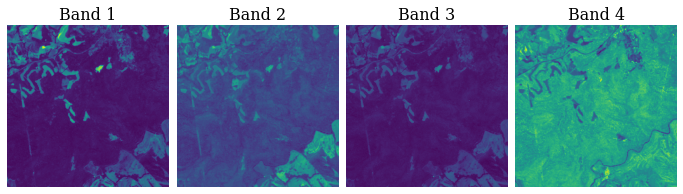

In [ ]:
# Show different bands
fig, axs = plt.subplots(1,4, figsize=(12,6))
axs[0].imshow(im_3.reshape(512,512,4)[:,:,0])
axs[1].imshow(im_3.reshape(512,512,4)[:,:,1])
axs[2].imshow(im_3.reshape(512,512,4)[:,:,2])
axs[3].imshow(im_3.reshape(512,512,4)[:,:,3])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')

axs[0].set_title('Band 1', size=16)
axs[1].set_title('Band 2', size=16)
axs[2].set_title('Band 3', size=16)
axs[3].set_title('Band 4', size=16)

fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig('4d-atlantic-bands.pdf', bbox_inches = 'tight', pad_inches = 0.1)

### Image 1

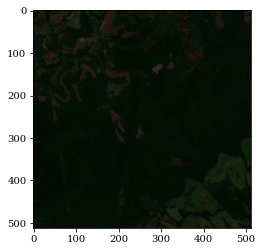

In [ ]:
# Original image
plt.imshow(im_3.reshape(512,512,4)[:,:,0:3])

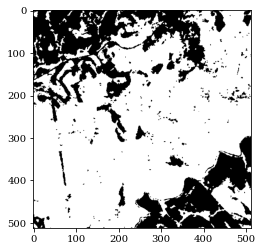

In [ ]:
# Ground truth mask
plt.imshow(mk_3.reshape(512,512), cmap = 'gray')

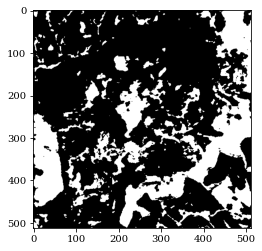

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

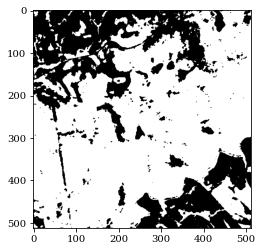

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

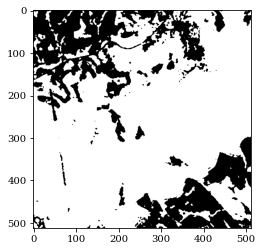

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

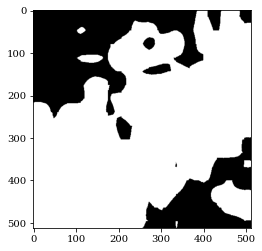

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_4d_atlantic, im_3, rounded = True, cmap = 'gray')

# Map of location of images

In [ ]:
def convert_to_coordinates(image_path):
  rasterized_image = rasterio.open(image_path)
  boundary = rasterized_image.bounds
  l = boundary.left
  b = boundary.bottom
  r = boundary.right
  t = boundary.top

  return ((l+r)/2, (t+b)/2)

In [ ]:
# Transformation matrix for coordinate system
file1 = 'AMAZON/Training/image/{}'.format(training_images_list2[0])
~rasterio.open(file1).transform

Affine(0.1, 0.0, -77164.0,
       0.0, -0.1, 878464.0)

In [ ]:
# Extract coordinates of train images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords = []
atlantic_coords = []

amazon_coords_train = []
for n in training_images_list2:
  data = gdal.Info('/content/AMAZON/Training/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_train.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_train = []
for n in training_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Training/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_train.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [ ]:
# Extract coordinates of validation images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords_validation = []
for n in validation_images_list2:
  data = gdal.Info('/content/AMAZON/Validation/images/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_validation.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_validation = []
for n in validation_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Validation/images/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_validation.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [ ]:
# Extract coordinates of test images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords_test = []
for n in test_images_list2:
  data = gdal.Info('/content/AMAZON/Test/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_test.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_test = []
for n in test_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Test/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_test.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [ ]:
map = folium.Map(location=[ 1.574822, -62.773457 ], zoom_start=5, tiles = 'cartodbpositron')

amazon_cluster = MarkerCluster().add_to(map)
atlantic_cluster = MarkerCluster().add_to(map)

# Draw images coordinates
for n in amazon_coords:
  #folium.CircleMarker(n, radius=10, weight=1, color='red', fill_color='red', fill_opacity=.05).add_to(map)
  folium.CircleMarker(n, radius=3, fill_opacity=0.1, fill_color='red', weight=2, color='red').add_to(map)
for n in atlantic_coords:
  #folium.CircleMarker(n, radius=10, weight=1, color='red', fill_color='red', fill_opacity=.05).add_to(map)
  folium.CircleMarker(n, radius=3, fill_opacity=0.1, fill_color='red', weight=2, color='red').add_to(map)

#
# Shapefile for Amazon from: http://worldmap.harvard.edu/data/geonode:amapoly_ivb
# Shapefile for others from: http://terrabrasilis.dpi.inpe.br/en/download-2/
#

af_shp            = shapefile.Reader('mata_atlantica_border.shp')
caatinga_shp      = shapefile.Reader('caatinga_border.shp')
cerrado_shp       = shapefile.Reader('limite_cerrado.shp')
pampa_shp         = shapefile.Reader('pampa_border.shp')
pantanal_shp      = shapefile.Reader('pantanal_border.shp')

style1 = {'fillColor': '#009940', 'color': '#004d20'}
style2 = {'fillColor': '#0000e6', 'color': '#0000b3'}

folium.GeoJson('amapoly_ivb.json', name="Amazon", style_function=lambda x:style2).add_to(map)
folium.GeoJson(af_shp, name="Atlantic Forest", style_function=lambda x:style2).add_to(map)
folium.GeoJson(caatinga_shp, name="Caatinga", style_function=lambda x:style1).add_to(map)
folium.GeoJson(cerrado_shp, name="Cerrado", style_function=lambda x:style1).add_to(map)
folium.GeoJson(pampa_shp, name="Pampa", style_function=lambda x:style1).add_to(map)
folium.GeoJson(pantanal_shp, name="Pantanal", style_function=lambda x:style1).add_to(map)

# Add heatmap of points
#HeatMap(amazon_coords+atlantic_coords, radius=40, max_zoom=5, min_opacity=0.25).add_to(map)
#HeatMap(atlantic_coords, radius=40, max_zoom=10, min_opacity=0.25).add_to(map)
map

In [ ]:
map.save('map.html')

## Export some images to .png to add to map

In [ ]:
im1_4d_amazon = validation_images2[9].reshape(512,512,4)[:,:,0:3]
im2_4d_amazon = validation_images2[6].reshape(512,512,4)[:,:,0:3]
im3_4d_amazon = validation_images2[8].reshape(512,512,4)[:,:,0:3]

im1_4d_atlantic = validation_images3[1].reshape(512,512,4)[:,:,0:3]
im2_4d_atlantic = validation_images3[2].reshape(512,512,4)[:,:,0:3]
im3_4d_atlantic = validation_images3[3].reshape(512,512,4)[:,:,0:3]

plt.imsave('im1_4d_amazon.png', im1_4d_amazon)
plt.imsave('im2_4d_amazon.png', im2_4d_amazon)
plt.imsave('im3_4d_amazon.png', im3_4d_amazon)

plt.imsave('im1_4d_atlantic.png', im1_4d_atlantic)
plt.imsave('im2_4d_atlantic.png', im2_4d_atlantic)
plt.imsave('im3_4d_atlantic.png', im3_4d_atlantic)

## Map showing where Amazon and Atlantic Forest is

@article{article,
author = {Oliveira-Ferreira, Joseli and Lacerda, Marcus and Brasil, Patrícia and Ladislau, José and Tauil, Pedro and Daniel-Ribeiro, Cláudio},
year = {2010},
month = {04},
pages = {115},
title = {Malaria in Brazil: An overview},
volume = {9},
journal = {Malaria journal},
doi = {10.1186/1475-2875-9-115}
}

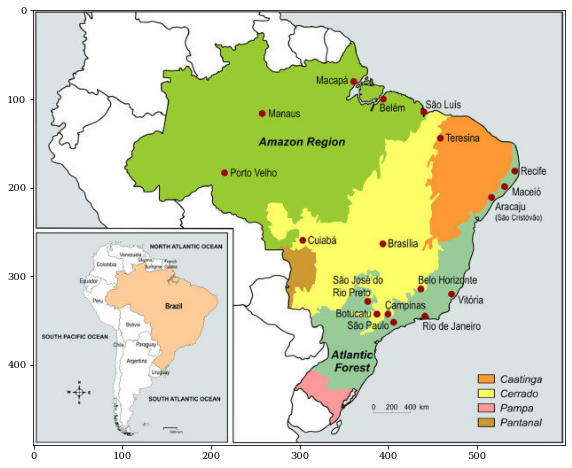

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(plt.imread('amazon-atlantic-forest-mapjpg.jpg'))

My own custom made map

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(plt.imread('Amazon-Map.png'))

# Plot training history

In [ ]:
unet_3d_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_3d_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

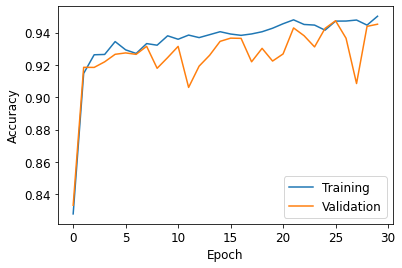

In [ ]:
# Plot accuracy and loss for U-Net 3d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(unet_3d_history['accuracy'])
plt.plot(unet_3d_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('unet-3d-accuracy.pdf')

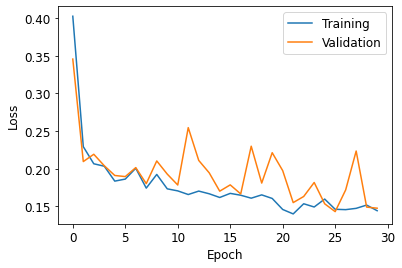

In [ ]:
## Loss
plt.plot(unet_3d_history['loss'])
plt.plot(unet_3d_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('unet-3d-loss.pdf')

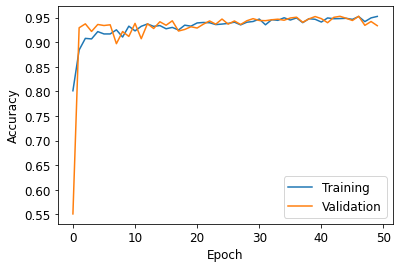

In [ ]:
# Plot accuracy and loss for Attention U-Net 3d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(attention_unet_3d_history['accuracy'])
plt.plot(attention_unet_3d_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('attention-unet-3d-accuracy.pdf')

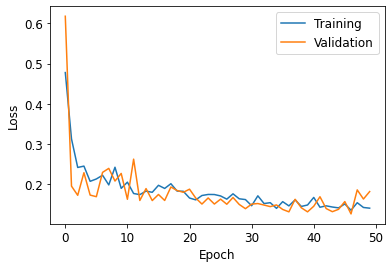

In [ ]:
## Loss
plt.plot(attention_unet_3d_history['loss'])
plt.plot(attention_unet_3d_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('attention-unet-3d-loss.pdf')

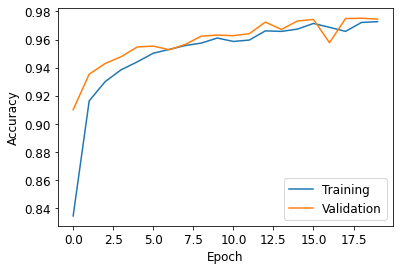

In [ ]:
# Plot accuracy and loss for U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('unet-4d-accuracy.pdf')

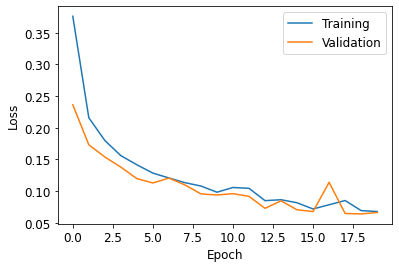

In [ ]:
## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('unet-4d-loss.pdf')

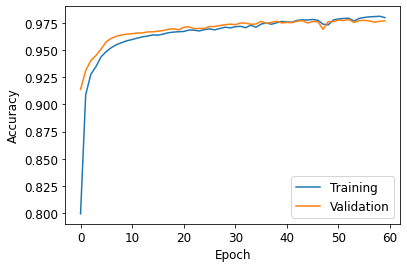

In [ ]:
# Plot accuracy and loss for Attention U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('attention-unet-4d-accuracy.pdf')

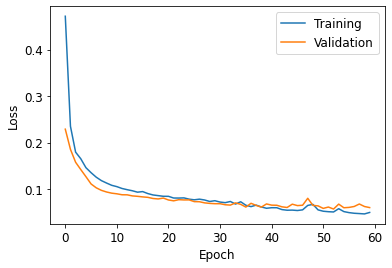

In [ ]:
## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('attention-unet-4d-loss.pdf')

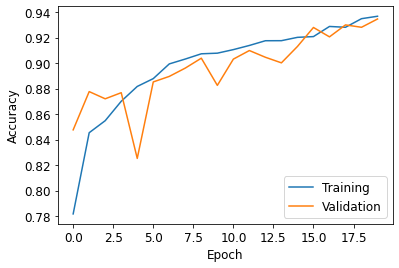

In [ ]:
# Plot accuracy and loss for U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('unet-4d-atlantic-accuracy.pdf')

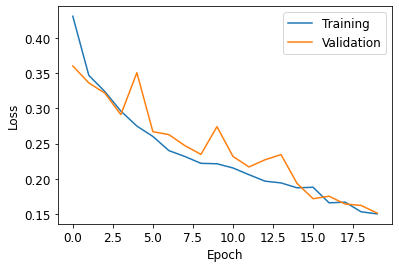

In [ ]:
# Plot accuracy and loss for U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('unet-4d-atlantic-loss.pdf')

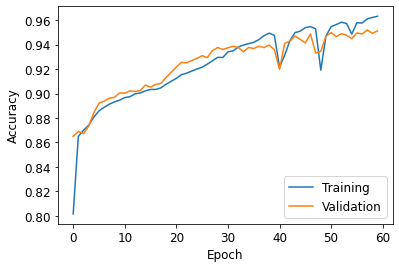

In [ ]:
# Plot accuracy and loss for Attention U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('attention-unet-4d-atlantic-accuracy.pdf')

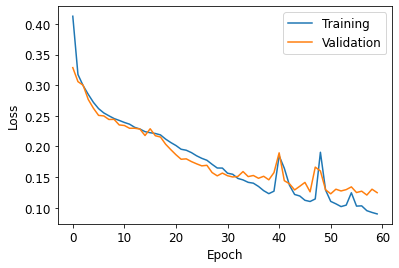

In [ ]:
# Plot accuracy and loss for Attention U-Net 4d data
plt.rcParams.update({'font.size': 12})
## Accuracy
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('attention-unet-4d-atlantic-loss.pdf')